In [1]:
import warnings
warnings.filterwarnings('ignore')

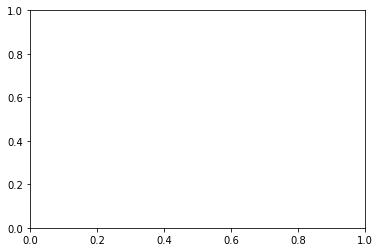

In [2]:
from plotting_utils import *

# A model for two mice in a small cage
###### Author
Mihai-Aurelian, Dumitrescu
mihai@bccn-berlin.de

##### Submitted to
Prof. Sprekeler
Modelling Seminar, winter 2020

## Problem statement: Two mice in a cage

The problem given to us was:

<a name="P1"></a>P1. We have two mice in a cage (in a 2-D or 1-D field).

<a name="P2"></a>P2. They don't like each other.

<a name="P3"></a>P3. Food is present in one given spot in the cage.

<a name="P4"></a>P4. There is only enough space for one mouse to eat at a time.

<a name="P5"></a>P5. They need to reproduce.

<a name="P6"></a>P6. They don't reproduce where they eat.

<a name="P7"></a>P7. After being full, mice don't find the feeding spot that attractive anymore.

We are interested in possible trajectories of the two mice.

## Assumptions

The problem description brings many details that can be modeled. A model taking every detail into consideration
can become quickly very complex.
Moreover, the profundity of biological details can become very quickly overwhelming.

For exemplification, however, we want to have a simplistic model that focuses on a couple of key aspects
of the problem.
Therefore, I will ignore some aspects specified in the problem description and will generalize over some biological
details.


### <a name="A1"></a>A1. The cage

I will assume the mice move inside idealized cages with infinitely high walls such that the mice are not influenced
in any way by the outside world.
The system is, thus, closed. Therefore, it's state dynamics depends only on variables that can be found inside
the cage and we have access to during the modelling task.

I will also assume one can observe the mice from above in an idealized way.
This means we always have access to their exact position and this reading is done noise free.

### <a name="A2"></a>A2. Biological variability of the mice physiology

I will assume that the actual physical biology of the mice is irrelevant for the problem at hand.
One could look for biologically plausible movement model of the mouse, in which arms, legs, joins, body and head geometry
are considered. However, I do not expect the quality of the desired outputted trajectories to improve dramatically.

As a consequence, in the attempt to keep complexity low, I will idealize the two mice inside a cage to point particles
that obey a system of coupled and nonlinear stochastic differential equations.

### <a name="A3"></a>A3. Movement of the mice

The problem does not express it explicitly, but I will assume that mice usually like exploring their
environments and are quite curious. This curiosity should be quantifiable and each mouse should
have its own parametrization.

### <a name="A4"></a>A4. Mating

Similarly to previous decisions, I will ignore many biologically plausible details, with 2 exceptions:

<a name="A4_1"></a>A4.1. I will assume there is a periodicity in the mating schedule, but keep this very basic.

<a name="A4_2"></a>A4.2. I will assume that proximity to the other mouse produces arousal i.e. even more desire to mate.


### <a name="A5"></a>A5. Feeding spot

The problem description does not come with many details about feeding. Therefore, I will try to keep feeding as
simple as possible.

I will assume that:

1. food is present in abundance for the mice.
2. there is no feeding schedule or any fixed time window in which feeding can be done.
3. mice are able to feed if they are close enough (a set radius distance apart) from the feeding spot.

As a consequence, infinite amount of food will be **always** present in the cage.
This means that the mice can feed as much and as often as they want.

### Details ignored from the problem description

#### 1. There is only enough space for one mouse to eat at a time
I will ignore *([P4](#P4))* from the problem description.
The reasoning is:
1. to the limit $\lim_{dt \rightarrow 0}$ two simultaneous feeding events are mathematically not possible.
2. this implies we can always find a small enough discretization s.t. two simultaneous are mathematically excluded.


Moreover, I ignore the fact the mice **might** get hungrier if they are close to the food spot
because the problem does not state this. Rather, the assumption is that they know how to navigate their environment
and they, somehow, **remember** the spot of the food.

#### 2. They don't reproduce where they eat
After implementing *(P1-P3), (P5), (P7)* I decided to ignore this detail to keep complexity low.
In the [discussions](#Discussion) section I will suggest how to add this aspect.

## Methods
My target is to obtain a system of couples differential equations.


### Closed form or simulation ?
Typically, mice take many decisions at each time step randomly, what for the outside observer might appear as totally random.
As a simplification, we can bundle all these random decisions in one stochastic process.

As a consequence, our system of differential equations becomes a system of **stochastic differential equations**.

Therefore, finding a closed form is very difficult, if not impossible.
I will concentrate in this report on simulating the model on a computer and not think about a
closed form solution of the model.

### Euler-Maruyama
Dynamical systems can be elegantly implemented using the **Forward Euler** method. **Forward Euler** works by
considering the first order Taylor expansion of the dynamical equation.

Due to the stochasticity mentioned above, simple **Forward Euler** does not work. The modelled
stochastic process requires a variance that is adapted to the chosen discretization step, usually denoted $\Delta_t$.
This method is called  **Euler-Maruyama** and is an extension of the **Forward Euler**
method [see [more details](#Movement-Model)].

Because it is very simple to implement, I will code the **Euler-Maruyama** integration scheme directly and
not use any external libraries.

### Splitting the problem into smaller ones

A dynamical system of differential equations can be seen as a <a name="grad"></a>gradient descent on an energy landscape.

Luckily, gradients are a vector field. Therefore, we can actually split the problem into smaller ones.
At the end we will be able to recover full expressivity of the model by linearly adding up these smaller components.

This is particularly advantageous when implementing the model because it allows me to split the problem into smaller ones,
that have, independently, manageable complexity.

Therefore, I will subsequently present, in isolation three models:
1. a movement model
2. a mating model
3. a feeding model

Our final model, the Mouse Model will be composed of the mentioned three models [see](#impl).

#### Movement Model

Implementing  [P1](#P1) , [A2](#A2) and [A3](#A3) (i.e. 2-D movement, point particles, exploring mice)
I find appropriate a brownian movement with white noise model. The component
of the movement model in the system of SDEs the becomes:

$$ \tau_{mouse}\frac{d\vec{m}}{dt} = \sigma_{mouse}\cdot\vec{\xi(t)}  \ \ (1) $$

where $ \vec{\xi(t)} \sim \mathcal{\vec{N}}(0,1)\$ is called noise.


The noise model I chose is gaussian white-noise, which is defined by the following two properties:

<a name="N1"></a>Noise 1. $<\vec{\xi_t} >  = \vec{0}$

<a name="N2"></a>Noise 2. $<\xi_t \cdot \xi_t' >  = \delta(t-t')$

where $\delta(t)$ is the **Dirac delta** generalized function.
The **Dirac delta** has the very important property that <a name="r_2"></a>$\int_{-\infty}^{\infty}\delta(t)dt=1 \ \ (2) $.


By multiplying both sides of eq. (1) with $dt$ we obtain:

$$ \tau_{mouse}d\vec{m} = \sigma_{mouse}\cdot dt \cdot \vec {\xi(t)} = \sigma_{mouse} \cdot dW_t \ \ (3) $$


Eq. (3) is
known in the literature as an Ornstein-Uhlenbeck stochastic process, $dW_{t}$ being the kernel.

Because we have to simulate the time evolution on a computer, we have to choose a discretization for our simulation
$dt \mapsto \Delta t $. Thus, we have [(Noise 2.)](#N2) in discrete form:
$<\xi_{\Delta t} \cdot \xi_{\Delta t}> = \frac {1}{\Delta t} $ to fulfill property [(2)](#r_2) of the Dirac delta i.e. integration
to exactly 1 value.

Thus:
$<\Delta W_{t}^2> = <\Delta\xi_{t}^2 \cdot \Delta t ^2>= \Delta t ^2 \cdot <\Delta\xi_{t}^2>=\frac{\Delta t ^2}{\Delta t}
= \Delta t$.

(3) becomes:
$ \tau_{mouse} \Delta \vec{m} = \sigma_{mouse} \cdot \ \sqrt {\Delta t} \cdot \vec {\xi_t} $ from which it follows that

$$ \tau_{mouse} \Delta \vec{m}_{movement} \sim \mathcal{N}(0,\,\sigma_{mouse}^{2}\cdot\Delta t)\ \ \ (4) $$

We can implement relationship (4) directly using the mentioned **Euler-Maruyama** scheme.

##### Typical trajectories

The 2-D brownian movement model produces, then, trajectories similar to:

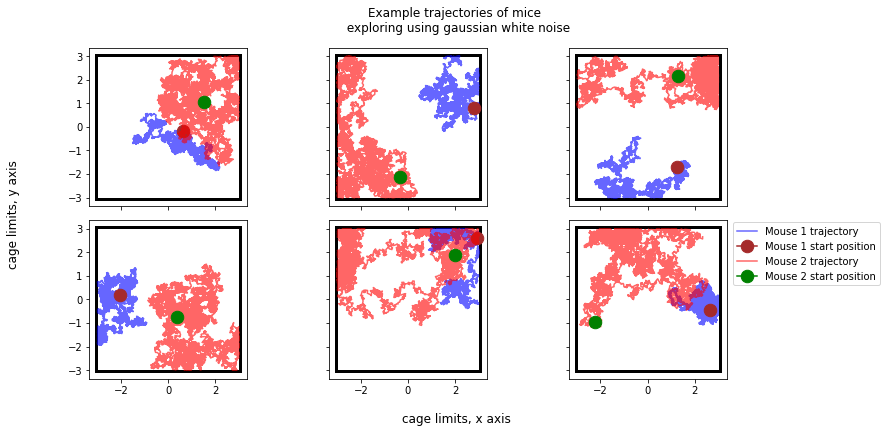

In [3]:
plot_example_exploration_trajectories()

#### Mating Model
Considering [P5](#P5) (mice need to reproduce) and [A5](#A5) (periodicity of mating period),
I chose as an appropriate model a model with 2 components.

##### Periodicity of mating desire

The first one takes into consideration the fact that mating desire is periodical.
For ease of implementation, I took $\sin(w_{mating} \cdot t)$  function.
The advantage of the sinusoidal function is that there is one parameter controlling
the periodicity and one for the start of the phase at the beginning os the simulation.

Sinusoidals also come with the advantage that they vary periodically in the interval [-1, 1].
In our case, the value 1 represents the fact that the two mice are attracting  (i.e. condition [P5](#P5)) each other
and -1 the fact that the mice are currently avoiding each other (i.e. condition [P2](#P2)).

##### Mating desire

The model takes into consideration [A4.2](#A4_2), the fact that mice are aroused with increased intensity as the other mouse is
in the vicinity.

As a consequence, I chose as an appropriate description a potential well of Gaussian shape.
When mating, from the perspective of the first mouse, there is an energy landscape with the lowest energy value
pointing to the other mouse.
The second mouse is, of course, handled symmetrically.

The mating energy model thus looks like:

$$E_{mating} = - \sin (w_{mating}t)\cdot \exp (-\dfrac {\left \| \vec{m_{1}} -\vec{m_{2}}\right \|^2}{\sigma_{mating} ^2 }) \ \ (5) $$


This produces, from the perspective of mouse 1, the following energy landscape:

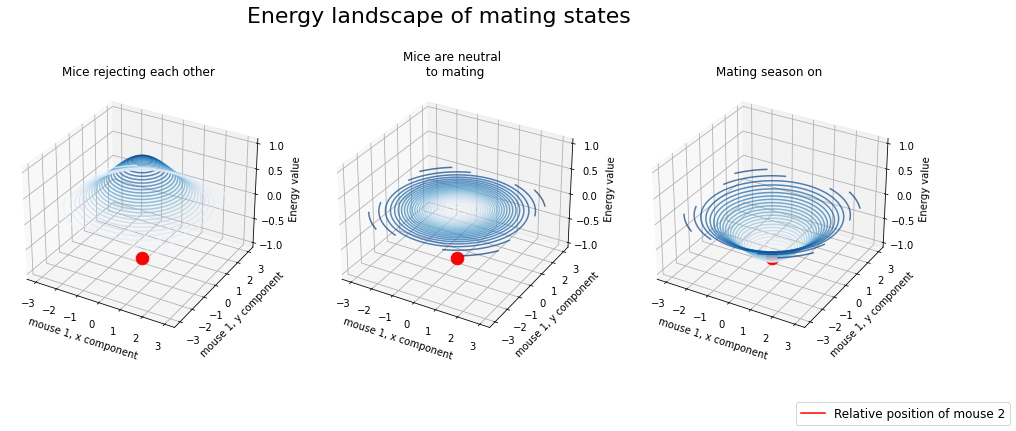

In [4]:
plot_mating_energy_landscape(figsize=(16,6))


As mentioned [before](#grad), the dynamics of the system is to do gradient descent on this energy landscape.

The gradient of mouse 1 follows from (5):

$$ \frac{\partial {E_{mating}} }{\partial \vec{m1}}= \sin (w_{mating}t) \cdot \frac {2}{\sigma_{mating} ^2} \cdot (\vec {m_1} - {\vec {m_2}})
\cdot \exp (-\dfrac {\left \| \vec{m_{1}} -\vec{m_{2}}\right \|^2}{\sigma_{mating} ^2 }) \ \ (6) $$

Here it is important that $\frac{\partial {E_{mating}}}{\partial \vec{m1}} \propto (\vec {m_1} - {\vec {m_2}}) $.

Due to gradient **descent**, depending on the value of $\sin (w_{mating}t)$ the system will either try to:

1. reduce the distance between $\vec{m_1}$ and $\vec{m_2}$ in case $\sin (w_{mating}t) = 1 $

2. increase the distance between $\vec{m_1}$ and $\vec{m_2}$ in case $\sin (w_{mating}t) = -1 $

thus implement either mating desire ([P5](#P5)) or rejection ([P2](#P2))\.

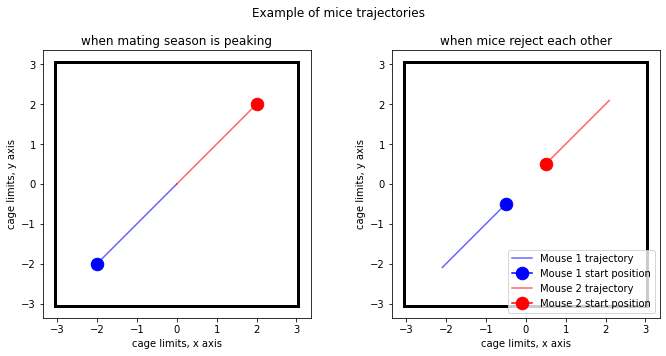

In [5]:
always_mating, always_rejecting = plot_mice_trajetories_for_mating_season_on_and_off(figsize=(10, 5))

One can also observe the evolution of the mating desire gradient length when mice
are closing in on each other.

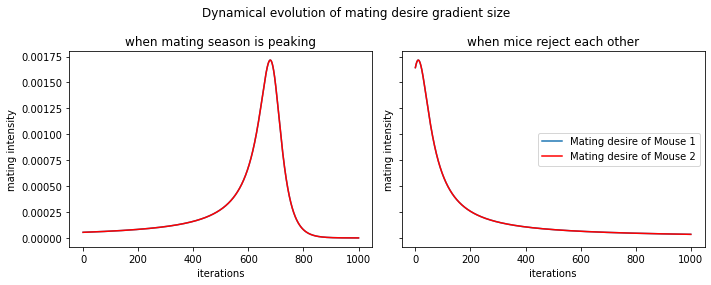

In [6]:
plot_mating_desire_gradients_for_mating_on_and_off(always_mating, always_rejecting, figsize=(10, 4))

As wanting to model:

1. during mating season, the closer they get to each other, the higher the attraction
2. during rejection season, the closer they get to each other the stronger they reject each other

#### Feeding Model

The feeding model is implemented with the same idea of an energy landscape as the **mating model** is.

Basically, I have modelled

$$E_{feeding} (t, \vec {m}) = {hunger_{max}} \cdot {\sigma}(t) \cdot || \vec {m} - \vec {food spot} || ^2 \ \ (7) $$

where

$$\sigma(t) = \frac {1} {1+ \exp(- \frac {t - (t_{lastfeeding} + {t_{hunger}})}{slope})}$$

$\vec {m}$ can be either $\vec {m_1}$ or $\vec {m_2}$ and $\vec {food spot}$ represents
the vector position of the center of the food spot considered from the centered of our
reference frame, the point $\vec {(0,0)}$.

From (7) is follows that:

$$ \frac{\partial E_{feeding}}{\partial \vec m_1} = 2 \cdot {hunger_{max}} \cdot {\sigma}(t) \cdot ( \vec {m} - \vec {food spot}) \ \ (8) $$


##### The strength of the hunger feeling

$\sigma(t)$ conveniently models how hungry a mouse currently is. I have chosen the sigmoidal function
because it can easily:

1. model the fact that, with time, the mice get hungrier
2. model the speed with which mice get hungrier by a slope parameter

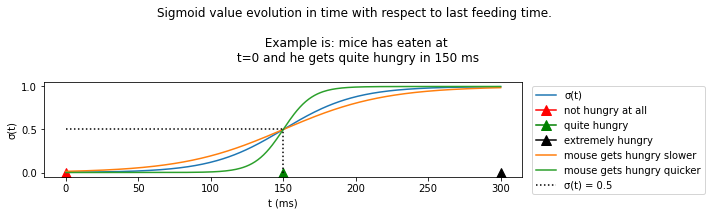

In [7]:
plot_sigmoid_function_output()

This produces, in isolation, the following example trajectory:

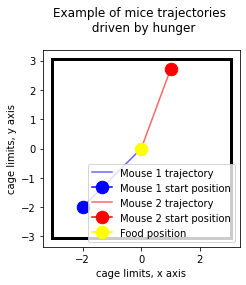

In [8]:
plot_feeding_example_trajectory(figsize=(7, 4))

The observation to be made here is that because there is nothing else to stop/interest them, mice will head towards the feeding spot.

## The Mice Model: combining all our simple models

$$ \tau_1\dot{\vec{m_1}} = \tau_1\frac{\vec{m_1}}{dt}= \sigma_{mouse}\cdot\xi(t) - \frac{\partial {E_{mating}} }{\partial \vec{m1}} - \frac{\partial {E_{feeding}} }{\partial \vec{m1}}
\newline
=\overbrace{\sigma_{mouse}\cdot\xi(t)}^{movement} - \underbrace{\sin (w_{mating}t) \cdot \frac {2}{\sigma_{mating} ^2} \cdot (\vec {m_1} - {\vec {m_2}})
\cdot \exp (-\dfrac {\left \| \vec{m_{1}} -\vec{m_{2}}\right \|^2}{\sigma_{mating} ^2 })}_{mating}
- \overbrace{{hunger_{max}} \cdot {\sigma}(t) \cdot || \vec {m_1} - \vec {food spot}||}^{feeding}
\newline
\tau_2\dot{\vec{m_2}}=\sigma_{2}\cdot\xi(t) - \sin (w_{mating}t) \cdot \frac {2}{\sigma_{mating} ^2} \cdot (\vec {m_2} - {\vec {m_1}})
\cdot \exp (-\dfrac {\left \| \vec{m_{2}} -\vec{m_{1}}\right \|^2}{\sigma_{mating} ^2 })
- hunger_{max} \cdot {\sigma}(t) \cdot || \vec {m_2} - \vec {food spot}||
$$



### Results
The model generates the following example trajectories:

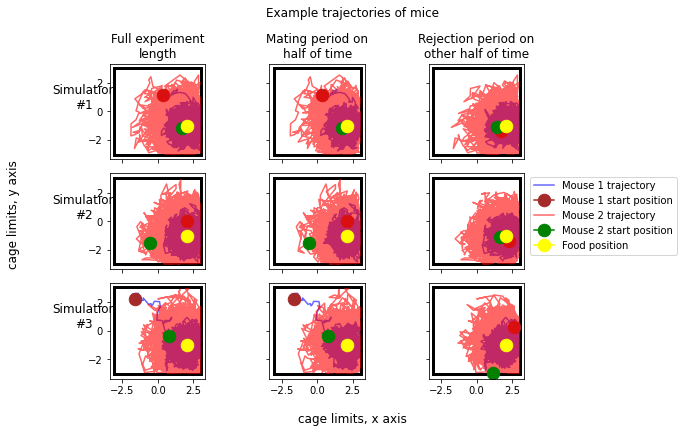

In [9]:
plot_example_full_trajectories(figsize=(10, 6))

It was quite difficult to place so much information on the graphs and they look quite heavy. Therefore, I chose split
the full trajectories from column 1 into two half trajectories, one during mating time, the other during rejection.

I would draw the attention to the following:

1. The start position at the beginning of the simmulation is drawn totally random and is irrelevant
2. The **start** position of the mice at the beginning of the *rejection* part is quite close, meaning the mice
have been drawn together by the mating desire
3. Because I did not implement the *they don't mate where they feed* feature, when hungry and mating the mice will be strongly
drawn to the feeding spot


The model is unable to predict a known feature of mice
(maybe due to ineffective parameter tuning) the fact that mice prefer to stay in corners when they reject each other).

## Discussion
In my opinion, the implementation looks elegant because each model (Movement, Mating, Food) works in isolation from
the others.

Although I tried to keep the model simple in the end it has many free variables.

The Movement Model comes with 2 free parameters: $ \sigma_{movement, mouse_1}, \sigma_{movement, mouse_2} $ that
controls the variance of $ dW_t $.

The Mating Model comes with 5 free parameters:

1. one $ \omega_{mating} $ - angular speed at which mating peak comes and goes
2. two $ \sigma_{mating, mouse} $ - how wide can the mice feel aroused by the other
3. two $ mating_{max, mouse} $ - how strong each mouse reacts to the mating desire

The Food Model comes with:

1. one feeding radius - how close must the mice be to be able to feed
2. two hunger maximum values
3. two $ t_{hunger, mouse} $ - controlling when the mouse gets hungry after he just fed

As a consequence we have 12 parameters we have to tweak and find a sweet spot in which the models are balanced.
This would mean that there is no particular model stronger than the others all the time.

This proved quite difficult and time laborious, hinting at the fact that the model is already quite complex.

I have not considered [P6](#P6), the fact that the mice don't reproduce where they eat. This could be implemented
by making the mating model accept two models as parameters:

1. This current mating model implementation
2. a high energy component with the center on the food spot, making the mice unavailable to reach the food spot while mating
season is on. This energy landscape is known as a **mexican hat** energy model.



### Appendix

#### <a name="impl"></a>Implementation Details
It was an interesting exercise to make the model:

1. testable
2. pluggable i.e. being able to turn on/off parts of the model to verify their contribution.
Thus, I have implemented the following structure

![Class Diagram](class_diagram.png).

The interesting part is that:

1. Euler-Maruyama is implemented only once, in the abstract class **Model**.
2. One could make a model fully extensible by providing a list of Models.
3. One must implement in each Model subclass the **gradient_step** method. Moreover, because each model has the
information if it is deterministic or stocastic, the proper scaling with $ \Delta_{t} $ must be implemented here.

Thus, the software is really modular.

The whole code base can be found [on github](https://github.com/midumitrescu/modelling-course-prof-sprek-winter-2022).



